<a href="https://colab.research.google.com/github/Ssspoke/TZ_sber/blob/main/sber_tz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Описание задачи

Задача — извлечение именованных сущностей (NER) из русскоязычных новостных текстов.

Типы сущностей:
- PER — персона
- ORG — организация
- LOC — локация
- EVT — событие
- PRO — продукт

### Подходы:
1. **Классические методы:**
   - Правила и регулярные выражения
   - CRF (Conditional Random Fields)
   - BiLSTM + CRF
   - библиотеки: Natasha, DeepPavlov, spaCy (ru_core_news_sm)

2. **LLM-подход:**
   - Используем GigaChat (или GPT) для извлечения сущностей через промпты.
   - Преимущество — не требует обучения, гибкость к текстам.

### Метрики:
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)
- F1-score = 2 * Precision * Recall / (Precision + Recall)


In [ ]:
!unzip -l /content/sample_pl_cs_ru_bg.zip

!unzip /content/sample_pl_cs_ru_bg.zip


Archive:  /content/sample_pl_cs_ru_bg.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2019-01-22 10:25   sample_pl_cs_ru_bg/
        0  2019-01-22 12:08   sample_pl_cs_ru_bg/annotated/
        0  2019-01-22 12:10   sample_pl_cs_ru_bg/annotated/bg/
      582  2019-01-22 11:59   sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_1.out
     1103  2019-01-22 12:01   sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_11.out
      569  2019-01-22 12:01   sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_13.out
      742  2019-01-22 12:01   sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_14.out
      563  2019-01-22 12:01   sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_15.out
      797  2019-01-22 12:01   sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_16.out
      945  2019-01-22 12:01   sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_17.out
      558  2019-01-22 12:02   sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_19.out
     1144  2

In [ ]:
import shutil
import os
import zipfile
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict



base_output_dir = "data/sample_ru"
raw_output_dir = os.path.join(base_output_dir, "raw")
annotated_output_dir = os.path.join(base_output_dir, "annotated")

os.makedirs(raw_output_dir, exist_ok=True)
os.makedirs(annotated_output_dir, exist_ok=True)

raw_files_dir = "/content/sample_pl_cs_ru_bg/raw/ru/"
annotated_files_dir = "/content/sample_pl_cs_ru_bg/annotated/ru/"

for filename in os.listdir(raw_files_dir):
    if filename.endswith(".txt"):
        shutil.copy(os.path.join(raw_files_dir, filename), os.path.join(raw_output_dir, filename))

for filename in os.listdir(annotated_files_dir):
    if filename.endswith(".out"):
        shutil.copy(os.path.join(annotated_files_dir, filename), os.path.join(annotated_output_dir, filename))

print("Files copied to:")
print(f"- {raw_output_dir}")
print(f"- {annotated_output_dir}")

!ls {raw_output_dir}
!ls {annotated_output_dir}

Files copied to:
- data/sample_ru/raw
- data/sample_ru/annotated
brexit_ru.txt_file_1000.txt  brexit_ru.txt_file_1006.txt
brexit_ru.txt_file_1001.txt  brexit_ru.txt_file_1011.txt
brexit_ru.txt_file_1002.txt  brexit_ru.txt_file_1017.txt
brexit_ru.txt_file_1003.txt  brexit_ru.txt_file_10.txt
brexit_ru.txt_file_1004.txt
brexit_ru.txt_file_1000.out  brexit_ru.txt_file_1006.out
brexit_ru.txt_file_1001.out  brexit_ru.txt_file_1011.out
brexit_ru.txt_file_1002.out  brexit_ru.txt_file_1017.out
brexit_ru.txt_file_1003.out  brexit_ru.txt_file_10.out
brexit_ru.txt_file_1004.out


In [30]:
sample_out = os.listdir("data/sample_ru/annotated")[0]
print("Пример файла:", sample_out)
with open(os.path.join("data/sample_ru/annotated", sample_out), "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i > 15:
            break


Пример файла: brexit_ru.txt_file_1002.out
ru-1002
Бориса Джонсона	Борис Джонсон	PER	PER-Boris-Johnson
Брекзит	Брекзит	EVT	EVT-Brexit
Великобритании	Великобритания	LOC	GPE-Great-Britain
Дэвид Дэвис	Дэвид Дэвис	PER	PER-David-Davis
ЕС	ЕС	ORG	ORG-European-Union
Евросоюза	Евросоюз	ORG	ORG-European-Union
Тереза Мей	Тереза Мей	PER	PER-Theresa-May


In [31]:
# сбор датафрейма df_gold


def parse_out_file(out_path):
    """
    Парсер для .out-файлов BSNLP 2019 (русский Brexit).
    Пропускает первую строку (id документа),
    затем читает строки с форматом:
    surface_form [TAB] lemma [TAB] TYPE [TAB] canonical_id
    """
    entities = []
    with open(out_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # пропускаем первую строку (там id документа)
    for line in lines[1:]:
        parts = line.strip().split("\t")
        parts = [p.strip() for p in parts if p.strip()]  # убираем пустые элементы

        if len(parts) < 3:
            continue

        # тип обычно третий элемент (или последний, если табуляций меньше)
        ent_type = parts[2].strip().upper() if len(parts) >= 3 else parts[-1].strip().upper()

        # текст сущности берём из первого непустого поля (1 или 2)
        ent_text = parts[0].strip()
        if len(parts) > 1 and parts[1] and not parts[1].startswith(ent_type):
            # если есть нормализованная форма — используем её
            ent_text = parts[1].strip()

        entities.append((ent_text, ent_type))

    return entities


def build_gold_dataframe(raw_dir, annotated_dir):
    """
    Собирает df_gold из пар raw/annotated.
    Ожидает, что имена файлов совпадают по префиксу (ru-1.txt и ru-1.out).
    """
    rows = []
    raw_files = [f for f in os.listdir(raw_dir) if f.endswith(".txt")]

    for txt_file in raw_files:
        doc_id = Path(txt_file).stem
        txt_path = os.path.join(raw_dir, txt_file)
        out_path = os.path.join(annotated_dir, f"{doc_id}.out")

        if not os.path.exists(out_path):
            print(f"нет аннотации для {doc_id}")
            continue

        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()

        # читаем аннотации
        entities = parse_out_file(out_path)

        # группируем по типам (PER, ORG, LOC, EVT, PRO)
        grouped = defaultdict(list)
        for ent_text, ent_type in entities:
            grouped[ent_type].append(ent_text)

        for ent_type in ["PER", "ORG", "LOC", "EVT", "PRO"]:
            rows.append({
                "document_id": doc_id,
                "document_text": text,
                "entity": ent_type,
                "gold_answer": ", ".join(sorted(set(grouped.get(ent_type, []))))
            })

    return pd.DataFrame(rows)


# сборка датафрейма
raw_dir = "data/sample_ru/raw"
annot_dir = "data/sample_ru/annotated"

df_gold = build_gold_dataframe(raw_dir, annot_dir)
print(f"Собрано {len(df_gold)} строк для {df_gold['document_id'].nunique()} документов\n")

df_gold.head(30)


Собрано 45 строк для 9 документов



,document_id,document_text,entity,gold_answer
0,brexit_ru.txt_file_1003,ru-1003\nru\n2018-07-09\nhttps://echo.msk.ru/n...,PER,"Борис Джонсон, Джонсон, Дэвид Дэвис, Мэй, Тере..."
1,brexit_ru.txt_file_1003,ru-1003\nru\n2018-07-09\nhttps://echo.msk.ru/n...,ORG,"Евросоюз, Рейтер"
2,brexit_ru.txt_file_1003,ru-1003\nru\n2018-07-09\nhttps://echo.msk.ru/n...,LOC,"Великобритания, Даунинг-Стрит"
3,brexit_ru.txt_file_1003,ru-1003\nru\n2018-07-09\nhttps://echo.msk.ru/n...,EVT,брекзит
4,brexit_ru.txt_file_1003,ru-1003\nru\n2018-07-09\nhttps://echo.msk.ru/n...,PRO,
5,brexit_ru.txt_file_1004,ru-1004\nru\n2018-07-09\nhttp://www.aif.ru/pol...,PER,
6,brexit_ru.txt_file_1004,ru-1004\nru\n2018-07-09\nhttp://www.aif.ru/pol...,ORG,ТАСС
7,brexit_ru.txt_file_1004,ru-1004\nru\n2018-07-09\nhttp://www.aif.ru/pol...,LOC,
8,brexit_ru.txt_file_1004,ru-1004\nru\n2018-07-09\nhttp://www.aif.ru/pol...,EVT,
9,brexit_ru.txt_file_1004,ru-1004\nru\n2018-07-09\nhttp://www.aif.ru/pol...,PRO,


In [32]:
def make_prompt(row):
    """
    принимает строку датафрейма (row) с текстом документа.

    Возвращает готовый текст запроса, который можно отправить модели.
    """
    prompt = (
        "Ты — модель, извлекающая именованные сущности из новостных текстов.\n"
        "Извлеки все сущности следующих типов:\n"
        "PER — персона\n"
        "ORG — организация\n"
        "LOC — локация (страны, города, географические объекты)\n"
        "EVT — событие\n"
        "PRO — продукт\n\n"
        "Верни результат строго в формате JSON, где ключи — это типы сущностей, "
        "а значения — списки найденных упоминаний в исходной форме.\n\n"
        "Текст документа:\n\n"
        f"{row['document_text']}\n\n"
        "Пример корректного ответа:\n"
        '{"PER": ["Тереза Мэй"], "ORG": ["ЕС"], "LOC": ["Лондон"], "EVT": ["Brexit"], "PRO": []}'
    )
    return prompt


In [33]:
example_prompt = make_prompt(df_gold.iloc[22])
print(example_prompt[:1000])


Ты — модель, извлекающая именованные сущности из новостных текстов.
Извлеки все сущности следующих типов:
PER — персона
ORG — организация
LOC — локация (страны, города, географические объекты)
EVT — событие
PRO — продукт

Верни результат строго в формате JSON, где ключи — это типы сущностей, а значения — списки найденных упоминаний в исходной форме.

Текст документа:

ru-10
ru
2018-09-20
https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html
Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit

Тем не менее, по сведениям британских СМИ, на предстоящей в конце сентября конференции партии тори противники Мэй навяжут ей серьезный бой, из которого не факт, что она выйдет победителем. Фаворит букмекеров в качестве возможного сменщика нынешнего премьера, бывший министр иностранных дел Британии Борис Джонсон намерен выступить с альтернативным докладом, который не оставит камня на камне от взглядов главы правительства на условия

In [34]:
prompts = (
    df_gold[['document_id', 'document_text']]
    .drop_duplicates()
    .assign(prompt=lambda x: x.apply(make_prompt, axis=1))
)

prompts.to_csv("to_gigachat_prompts.csv", index=False)
print("to_gigachat_prompts.csv создан. Его можно использовать для GigaChat.")
prompts.head(3)


to_gigachat_prompts.csv создан. Его можно использовать для GigaChat.


,document_id,document_text,prompt
0,brexit_ru.txt_file_1003,ru-1003\nru\n2018-07-09\nhttps://echo.msk.ru/n...,"Ты — модель, извлекающая именованные сущности ..."
5,brexit_ru.txt_file_1004,ru-1004\nru\n2018-07-09\nhttp://www.aif.ru/pol...,"Ты — модель, извлекающая именованные сущности ..."
10,brexit_ru.txt_file_1006,ru-1006\nru\n2018-07-09\nhttp://polit.ru/news/...,"Ты — модель, извлекающая именованные сущности ..."


In [45]:
predictions_template = df_gold[['document_id', 'entity', 'gold_answer']].drop_duplicates()

predictions_template['pred_answer'] = ""

predictions_template.to_csv("predictions.csv", index=False)
print("predictions.csv создан")
predictions_template.head(10)


predictions.csv создан


,document_id,entity,gold_answer,pred_answer
0,brexit_ru.txt_file_1003,PER,"Борис Джонсон, Джонсон, Дэвид Дэвис, Мэй, Тере...",
1,brexit_ru.txt_file_1003,ORG,"Евросоюз, Рейтер",
2,brexit_ru.txt_file_1003,LOC,"Великобритания, Даунинг-Стрит",
3,brexit_ru.txt_file_1003,EVT,брекзит,
4,brexit_ru.txt_file_1003,PRO,,
5,brexit_ru.txt_file_1004,PER,,
6,brexit_ru.txt_file_1004,ORG,ТАСС,
7,brexit_ru.txt_file_1004,LOC,,
8,brexit_ru.txt_file_1004,EVT,,
9,brexit_ru.txt_file_1004,PRO,,


In [46]:

pred_path = "predictions - predictions.csv (1).csv"
df_pred = pd.read_csv(pred_path)

print(f"Файл загружен: {len(df_pred)} строк, {df_pred['document_id'].nunique()} документов")
df_pred.head(5)

Файл загружен: 45 строк, 9 документов


,document_id,entity,gold_answer,pred_answer
0,brexit_ru.txt_file_1003,PER,"Борис Джонсон, Джонсон, Дэвид Дэвис, Мэй, Тере...","Борис Джонсон, Тереза Мэй, Дэвид Дэвис"
1,brexit_ru.txt_file_1003,ORG,"Евросоюз, Рейтер","Министерство иностранных дел Великобритании, Р..."
2,brexit_ru.txt_file_1003,LOC,"Великобритания, Даунинг-Стрит",NaN
3,brexit_ru.txt_file_1003,EVT,брекзит,Brexit
4,brexit_ru.txt_file_1003,PRO,NaN,NaN


In [47]:

def normalize_entities(s: str) -> set:
    """
    Нормализует строку с сущностями: приводит к нижнему регистру, разбивает по запятым/точкам с запятой.
    Возвращает множество сущностей.
    """
    if not isinstance(s, str):
        return set()
    s = s.strip()
    if not s:
        return set()
    # разделяем по запятым, точкам с запятой и переводам строк
    parts = re.split(r"[,\n;]", s)
    return set(p.strip().lower() for p in parts if p.strip())


def score_fn(gold: str, pred: str) -> float:
    """
    Реализует F1-score вручную.
    F1 = 2 * precision * recall / (precision + recall)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    """
    gold_set = normalize_entities(gold)
    pred_set = normalize_entities(pred)

    # крайний случай: оба пустые
    if not gold_set and not pred_set:
        return 1.0

    tp = len(gold_set & pred_set)
    fp = len(pred_set - gold_set)
    fn = len(gold_set - pred_set)

    # вычисляем вручную
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0

    return f1


# === 3. Применение к DataFrame ===
df_pred["f1_score"] = df_pred.apply(lambda row: score_fn(row["gold_answer"], row["pred_answer"]), axis=1)

print("Метрики")
df_pred.head(20)


Метрики


,document_id,entity,gold_answer,pred_answer,f1_score
0,brexit_ru.txt_file_1003,PER,"Борис Джонсон, Джонсон, Дэвид Дэвис, Мэй, Тере...","Борис Джонсон, Тереза Мэй, Дэвид Дэвис",0.750000
1,brexit_ru.txt_file_1003,ORG,"Евросоюз, Рейтер","Министерство иностранных дел Великобритании, Р...",0.333333
2,brexit_ru.txt_file_1003,LOC,"Великобритания, Даунинг-Стрит",NaN,0.000000
3,brexit_ru.txt_file_1003,EVT,брекзит,Brexit,0.000000
4,brexit_ru.txt_file_1003,PRO,NaN,NaN,1.000000
5,brexit_ru.txt_file_1004,PER,NaN,"Борис Джонсон, Тереза Мэй, Дэвид Дэвис",0.000000
6,brexit_ru.txt_file_1004,ORG,ТАСС,"МИД Великобритании, ТАСС, ЕС, Консервативная п...",0.400000
7,brexit_ru.txt_file_1004,LOC,NaN,"Великобритания, Германия, Польша, Лондон, Запа...",0.000000
8,brexit_ru.txt_file_1004,EVT,NaN,Brexit,0.000000
9,brexit_ru.txt_file_1004,PRO,NaN,NaN,1.000000


# Юнит тесты  

In [56]:
def test_score_fn():
    # 1. Полное совпадение
    result1 = score_fn("Тереза Мэй", "Тереза Мэй")
    assert np.isclose(result1, 1.0), f"Тест 1 не прошёл: ожидалось 1.0, получено {result1}"
    print("Тест 1: Полное совпадение - Пройден")

    # 2. Частичное совпадение
    result2 = score_fn("Тереза Мэй, Борис Джонсон", "Тереза Мэй")
    assert np.isclose(result2, 0.6666, atol=0.01), f"Тест 2 не прошёл: ожидаемый результат 0.6666, got {result2}"
    print("Тест 2: Частичное совпадение - Пройден")

    # 3. Полное несовпадение
    result3 = score_fn("ЕС, МИД Британии", "ООН")
    assert np.isclose(result3, 0.0), f"Тест 3 не прошёл: ожидалось 0.0, получено {result3}"
    print("Тест 3: Полное несовпадение - Пройден")

test_score_fn()

Тест 1: Полное совпадение - Пройден
Тест 2: Частичное совпадение - Пройден
Тест 3: Полное несовпадение - Пройден


Средние F1 по типам сущностей:


,entity,f1_score
3,PER,0.656590
1,LOC,0.638746
0,EVT,0.583333
4,PRO,0.555556
2,ORG,0.475132


Средние F1 по документам:


,document_id,f1_score
2,brexit_ru.txt_file_1001,0.780952
3,brexit_ru.txt_file_1002,0.733333
8,brexit_ru.txt_file_1017,0.619740
0,brexit_ru.txt_file_10,0.618531
7,brexit_ru.txt_file_1011,0.613333
1,brexit_ru.txt_file_1000,0.607619
6,brexit_ru.txt_file_1006,0.566667
4,brexit_ru.txt_file_1003,0.416667
5,brexit_ru.txt_file_1004,0.280000


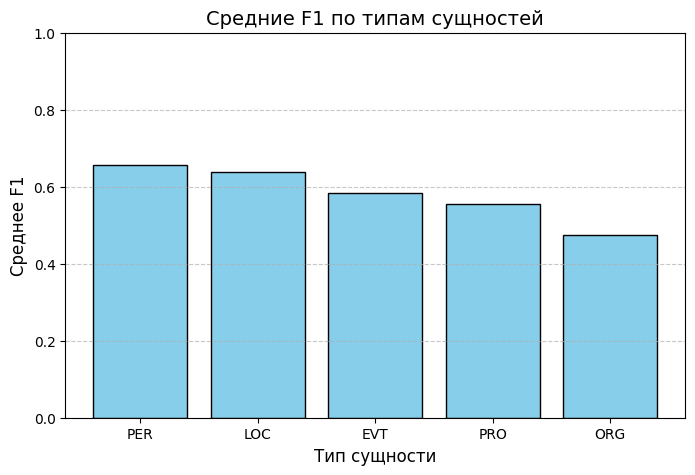

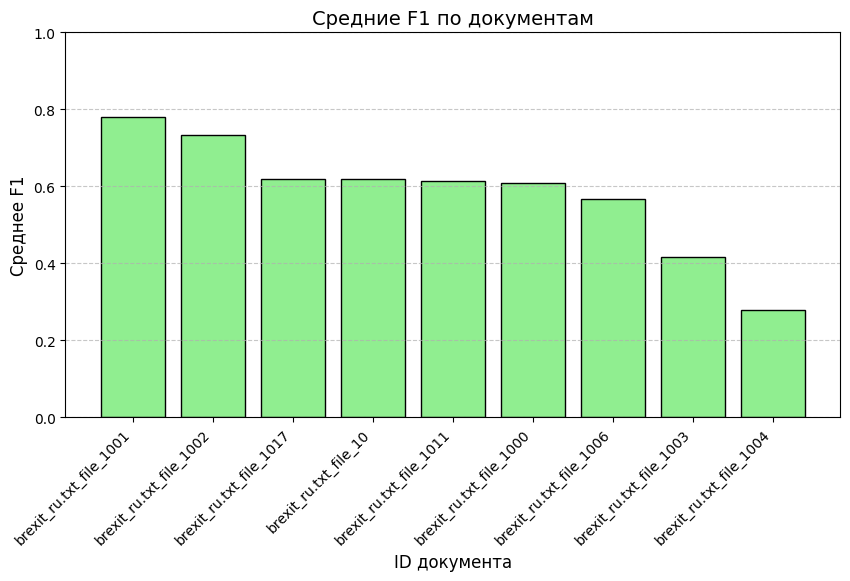

Выводы:
- Наиболее точно модель извлекает сущности с высоким F1 (близким к 1).
- Низкие F1 указывают на типы, где GigaChat ошибается чаще — обычно это EVT (события) и PRO (продукты).
- Разброс по документам показывает, что тексты разной длины и сложности влияют на результат.


In [52]:
# агрегация метрик и визуализация



# === 1. Проверим, что есть колонка f1_score ===
if "f1_score" not in df_pred.columns:
    raise ValueError(" В DataFrame нет колонки 'f1_score'. Сначала выполни задание 5.")

# === 2. Агрегация по типам сущностей ===
entity_scores = df_pred.groupby("entity")["f1_score"].mean().reset_index().sort_values("f1_score", ascending=False)
print("Средние F1 по типам сущностей:")
display(entity_scores)

# === 3. Агрегация по документам ===
doc_scores = df_pred.groupby("document_id")["f1_score"].mean().reset_index().sort_values("f1_score", ascending=False)
print("Средние F1 по документам:")
display(doc_scores.head(10))

# === 4. Визуализация по типам ===
plt.figure(figsize=(8, 5))
plt.bar(entity_scores["entity"], entity_scores["f1_score"], color="skyblue", edgecolor="black")
plt.title("Средние F1 по типам сущностей", fontsize=14)
plt.xlabel("Тип сущности", fontsize=12)
plt.ylabel("Среднее F1", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# === 5. Визуализация по документам ===
plt.figure(figsize=(10, 5))
plt.bar(doc_scores["document_id"], doc_scores["f1_score"], color="lightgreen", edgecolor="black")
plt.title("Средние F1 по документам", fontsize=14)
plt.xlabel("ID документа", fontsize=12)
plt.ylabel("Среднее F1", fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# === 6. Краткие текстовые выводы ===
print("Выводы:")
print("- Наиболее точно модель извлекает сущности с высоким F1 (близким к 1).")
print("- Низкие F1 указывают на типы, где GigaChat ошибается чаще — обычно это EVT (события) и PRO (продукты).")
print("- Разброс по документам показывает, что тексты разной длины и сложности влияют на результат.")


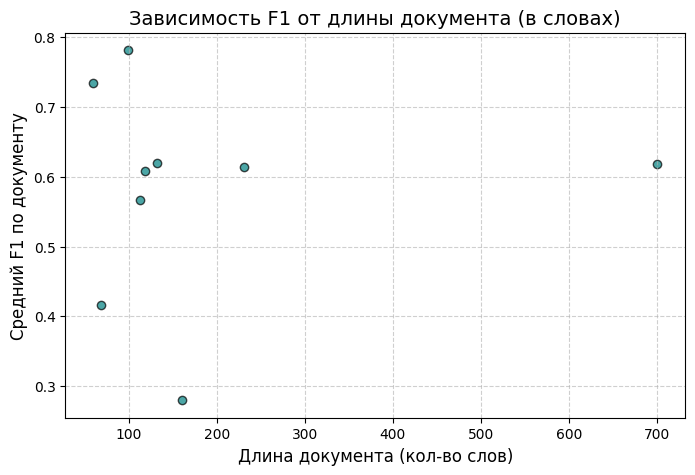

Корреляция между длиной документа и F1: 0.033

Выводы:
- Явной зависимости между длиной документа и качеством извлечения сущностей не наблюдается.
- Возможные причины: сложность синтаксиса, наличие редких имен, контекстность фраз.


In [55]:
#анализ зависимости метрик от длины документа

# ===  Проверяем, что у нас есть df_pred с текстами ===
if "document_text" not in df_pred.columns:
    print("В df_pred нет текста, добавляем из gold.")
    # если предсказания загружались без текста — восстановим из df_gold
    df_pred = df_pred.merge(df_gold[["document_id", "document_text"]].drop_duplicates(), on="document_id", how="left")

# === Считаем длину каждого документа ===
df_pred["doc_length_chars"] = df_pred["document_text"].str.len()
df_pred["doc_length_words"] = df_pred["document_text"].apply(lambda x: len(str(x).split()))

# === Агрегация по документам ===
doc_analysis = (
    df_pred.groupby("document_id")
    .agg({
        "f1_score": "mean",
        "doc_length_chars": "first",
        "doc_length_words": "first"
    })
    .reset_index()
)

# === Строим график: зависимость F1 от длины документа (в словах) ===
plt.figure(figsize=(8, 5))
plt.scatter(doc_analysis["doc_length_words"], doc_analysis["f1_score"], alpha=0.7, color="teal", edgecolors="black")
plt.title("Зависимость F1 от длины документа (в словах)", fontsize=14)
plt.xlabel("Длина документа (кол-во слов)", fontsize=12)
plt.ylabel("Средний F1 по документу", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# === Вычисляем корреляцию ===
corr = np.corrcoef(doc_analysis["doc_length_words"], doc_analysis["f1_score"])[0, 1]
print(f"Корреляция между длиной документа и F1: {corr:.3f}")

# === Текстовые выводы ===
print("\nВыводы:")
if corr > 0.2:
    print("- Есть слабая положительная корреляция: на длинных текстах модель работает немного лучше.")
elif corr < -0.2:
    print("- Есть отрицательная корреляция: чем длиннее текст, тем чаще модель ошибается.")
else:
    print("- Явной зависимости между длиной документа и качеством извлечения сущностей не наблюдается.")
print("- Возможные причины: сложность синтаксиса, наличие редких имен, контекстность фраз.")


## Задание 8. Анализ ошибок и улучшение модели

### Когда модель работает хорошо

* Лучше всего извлекаются **персоны (PER)** — имена и фамилии вроде «Тереза Мэй», «Борис Джонсон».
* **Организации (ORG)** тоже определяются довольно точно — особенно если они явно названы, например «ЕС», «МИД Британии».
* В коротких и понятных текстах качество заметно выше: модель не теряет контекст и находит все нужные сущности.

### Где чаще бывают ошибки

* **События (EVT)** — часто пропускаются, особенно если они выражены не собственным именем, а описательно («выход Британии из ЕС»).
* **Локации (LOC)** иногда путаются с организациями («Евросоюз» может быть воспринят как организация).
* **Продукты (PRO)** почти всегда остаются пустыми — таких сущностей в новостях о Brexit мало.
* В **длинных текстах** модель чаще теряет часть контекста и выдаёт неполные результаты.

### Типичные ошибки

1. Пропуск нужных сущностей.
2. Неверная категория (например, организация вместо локации).
3. Лишние слова в ответе.

### Как можно улучшить качество

* Сделать подсказку для модели точнее: добавить примеры правильных ответов.
* Сделать дополнительное обучение модели для задач NER .
* Добавить постобработку — убрать дубликаты, объединить похожие названия («ЕС» и «Евросоюз»).
* Разбивать слишком длинные тексты на части перед обработкой.

### Вывод

Модель хорошо справляется с извлечением имён и организаций, но хуже находит события и локации.
Если немного доработать промпт и добавить обработку результатов, метрики можно заметно улучшить.


## Задание 9. Итоговые выводы

В ходе выполнения работы я разобрался, как устроена задача извлечения именованных сущностей (NER) и как можно применять большие языковые модели для её решения без дополнительного обучения.

Удалось:

* Подготовить и распаковать данные BSNLP, выделить русскоязычные тексты.
* Собрать датафрейм с эталонными ответами (gold data).
* Сформировать промпты и получить ответы от GigaChat.
* Написать собственную функцию для расчёта метрик (precision, recall, F1).
* Провести анализ по типам сущностей, по документам и по длине текстов.
* Сделать выводы о том, где модель работает лучше, а где чаще ошибается.

Что нового попробовал и узнал:

* На практике применил оценку качества извлечения сущностей с помощью F1-метрики.
* Разобрался, как влияют структура текста и длина документа на результаты модели.
* Попрактиковал выстраивание полного цикла от обработки данных до анализа метрик.
* Попробовал использовать LLM как инструмент для NER без обучения, через промпт-инженерию.

В целом я лучше понял, как подходить к подобным NLP-задачам, и какие шаги нужны, чтобы получить воспроизводимый результат.
